# Text Area Detection PoC (Translue)

---
<br>

**Vision:**
Given an image, make sure that text within the image is detected. The characters themselves are not yet to be identified, just the text as such.

In [36]:
# Importing dependencies / required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import keras
import cv2
from datetime import datetime
from Utils import *
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Model
from keras.models import model_from_json

## Define the model

In [59]:
img_w = 512    # Width of image (static)
img_h = 512    # Height of image (static)
channels = 3   # Amount of color channels (Red, Green, Blue)
classes = 1    # Image classes (not necessary for us)
info = 5       # Information depth (Y is 16x16x5, so its 5)
grid_w = 16    # Image grid width
grid_h = 16    # Image grid height

In [61]:
# Misc
model_file  = "model/detector_model.json"
weight_file = "model/detector_weights.h5"
pruned_keras_file = "model/detector_weights_keras_pruned.h5"
pruned_tflight_file = "model/detector_weights_tflight_pruned.tflite"

In [3]:
#%run -i "Preprocess.py" # Creating training input and labels

In [4]:
# Import preprocessed features and labels (X= Input to the net, Y= Ground Image Matrix)
# (X and Y numpy arrays are created with Prepocess.py <- Run this first!)
X = np.load('Data/X.npy')
Y = np.load('Data/Y.npy')

In [5]:
# We should get 461 512x512 images, each with 3 color channels (RGB)
# We measure the network by putting in the images and measuring the network output with
# 461 16x16(x1)x5 ground truth containing matrices (contains recangle info on text regions)
print(X.shape, Y.shape)

(461, 512, 512, 3) (461, 16, 16, 1, 5)


In [6]:
# Split this dataset: 75% to train the network with, 25% to measure performance
X_train, X_val, Y_train, Y_val  = train_test_split(X, Y, train_size = 0.75, shuffle = True)

In [7]:
# Defining the network model
# Input : 512,512,3 (the image's color-pixel matrix)
# Output : 16,16,1,5 (matrix containing found images)

# Store training results
def save_model(model):
    model_json = model.to_json()
    with open(model_file, "w") as json_file:
        json_file.write(model_json)

# Load a previously trained model
def load_model(strr):        
    json_file = open(strr, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    return loaded_model
    
# This is the actual network model, based on the YOLO approach
# which we in turn based on the pre-existing MobileNetV2
def translue_model(input_shape):
    inp = Input(input_shape)
   
    # Load a library's pre-trained model as basis
    model = MobileNetV2(input_tensor=inp, include_top=False, weights='imagenet')
    last_layer = model.output
    
    # We extend ModileNetV2 by these neural layers:
    conv = Conv2D(512, (3,3), activation='relu', padding='same')(last_layer)
    conv = Dropout(0.4)(conv) # This, we need this! It's really good!
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    conv = Conv2D(128, (3,3), activation='relu', padding='same')(lr)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    conv = Conv2D(5, (3,3), activation='relu', padding='same')(lr)
    final = Reshape((grid_h, grid_w, classes, info))(conv)
    
    # This is the new, complete model
    model = Model(inp, final)
    
    return model

In [8]:
# Use an Adam Optimizer during training
opt = Adam(lr=0.000005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# Checkpoint to possibly continue with a partially trained model
checkpoint = ModelCheckpoint(weight_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)

F:\Programs\Python\Python310\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
# Define the cost function
# Network's y_true dim:      16,16,1,5
# Ground Truth's y_pred dim: 16,16,1,5

def loss_func(y_true, y_pred):
    l_coords = 5.0
    l_noob = 0.5
    coords = y_true[:,:,:,:,0] * l_coords
    noobs = (-1 * (y_true[:,:,:,:,0] - 1) * l_noob)
    
    p_pred  = y_pred[:,:,:,:,0]
    p_true  = y_true[:,:,:,:,0]
    x_true  = y_true[:,:,:,:,1]
    x_pred  = y_pred[:,:,:,:,1]
    yy_true = y_true[:,:,:,:,2]
    yy_pred = y_pred[:,:,:,:,2]
    w_true  = y_true[:,:,:,:,3]
    w_pred  = y_pred[:,:,:,:,3]
    h_true  = y_true[:,:,:,:,4]
    h_pred  = y_pred[:,:,:,:,4]
    
    p_loss_absent = K.sum(K.square(p_pred - p_true) * noobs)
    p_loss_present = K.sum(K.square(p_pred - p_true))
    p_loss = p_loss_absent + p_loss_present
    
    x_loss = K.sum(K.square(x_pred - x_true) * coords)
    yy_loss = K.sum(K.square(yy_pred - yy_true) * coords)
    xy_loss = x_loss + yy_loss
    
    w_loss = K.sum(K.square(w_pred - w_true) * coords)
    h_loss = K.sum(K.square(h_pred - h_true) * coords)
    wh_loss = w_loss + h_loss
    
    loss = p_loss + xy_loss + wh_loss
    
    return loss

In [10]:
# Load and save model
input_size = (img_h, img_w, channels)

model = translue_model(input_size)
print(model.summary())

save_model(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 256, 256, 32  128         ['Conv1[0][0]']                  
                                )                                                             

## Training the model (Caution)

In [20]:
# Load pre-trained weights (from previous training iterations)
model.load_weights(weight_file)

In [21]:
model.compile(loss=loss_func, optimizer=opt, metrics = ['accuracy'])

In [22]:
# [!] CAUTION - This trains the model 30x on 4 random images
# Uncomment below only if you have time and a powerful machine
# Below approach is outdated now, but it shows the idea of what's happening
hist = model.fit(X_train, Y_train, epochs=1, batch_size=40, callbacks=[checkpoint], validation_data=(X_val, Y_val))

9/9 [==============================] - ETA: 0s - loss: 21.8201 - accuracy: 0.0507 
Epoch 1: val_loss did not improve from 28.87713
9/9 [==============================] - 214s 23s/step - loss: 21.8201 - accuracy: 0.0507 - val_loss: 28.8916 - val_accuracy: 0.0477


In [23]:
# After training: Save training progress on the model
model.save_weights(weight_file)

## Evaluate the model

In [24]:
# Load the most recent model from files
model = load_model(model_file)
model.load_weights(weight_file)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


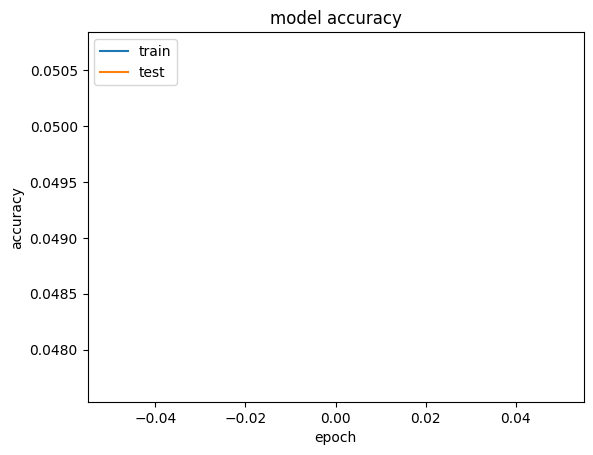

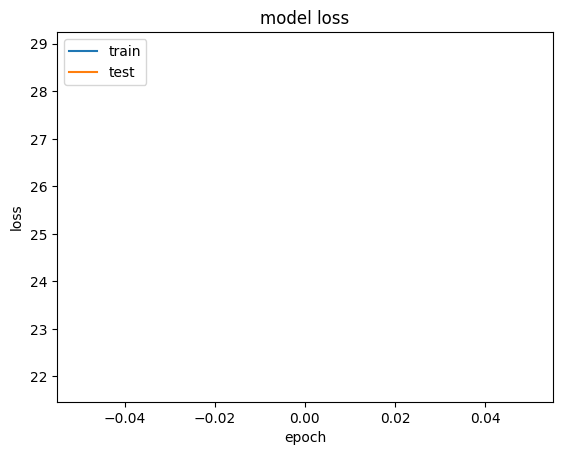

<Figure size 640x480 with 0 Axes>

In [25]:
%matplotlib inline

print(hist.history.keys())

# Summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('accuracy.png')

# Summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('loss.png')

In [26]:
def predict_func(model, inp, iou, name):

    ans = model.predict(inp)
    boxes = decode(ans[0], img_w, img_h, iou)
    img = ((inp + 1) / 2)
    img = img[0]

    # Draw boxes by their coordinates
    for i in boxes:
        i = [int(x) for x in i]
        img = cv2.rectangle(img, (i[0], i[1]), (i[2], i[3]), color = (0,255,0), thickness = 2)

    plt.imshow(img)
    plt.show()
    
    cv2.imwrite(os.path.join('Results', str(name) + '.jpg'), img * 255.0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


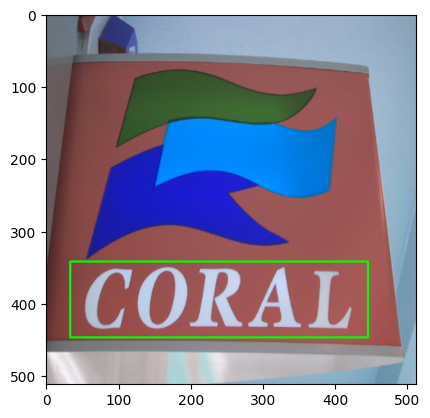

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


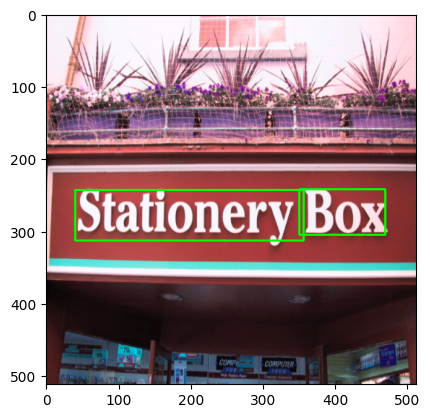

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


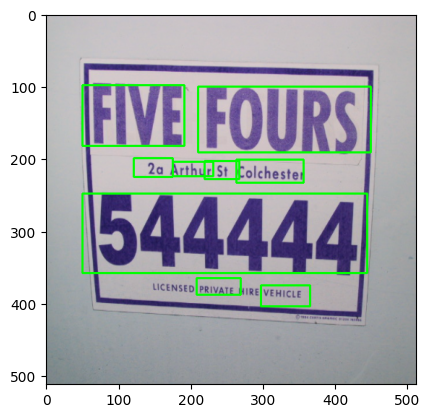

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


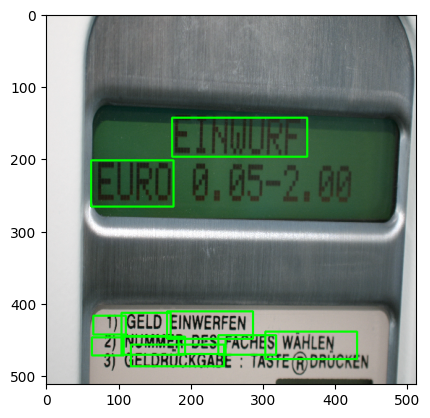

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


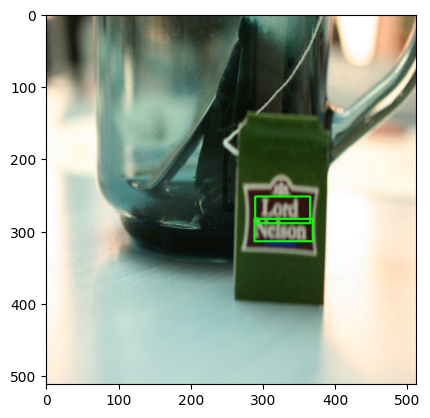

In [27]:
rand = np.random.randint(0, X_val.shape[0], size = 5)

for i in rand:
    predict_func(model, X_val[i:i+1], 0.5, i)

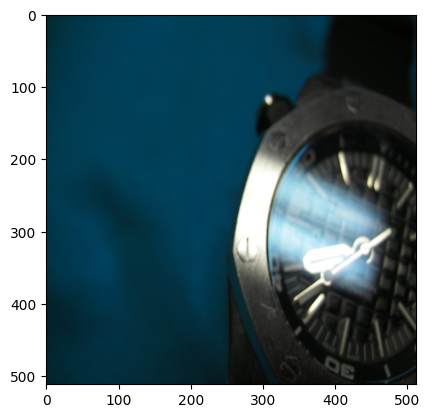

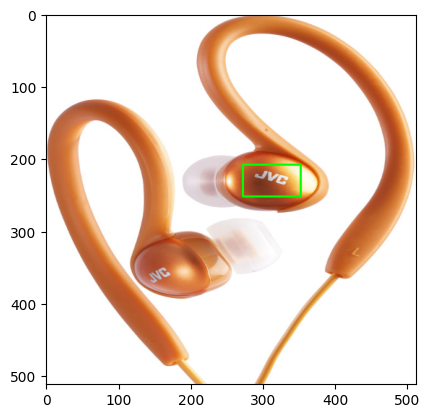

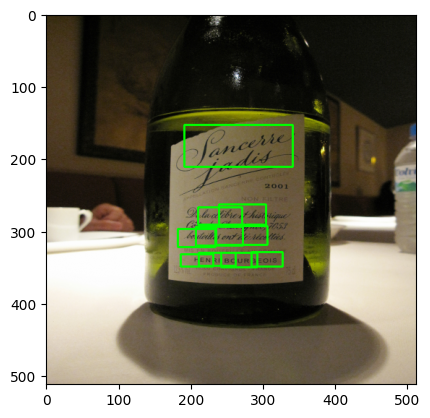

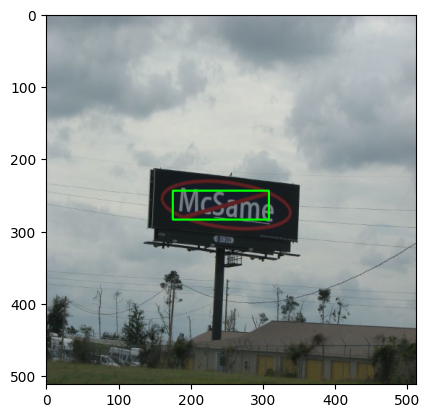

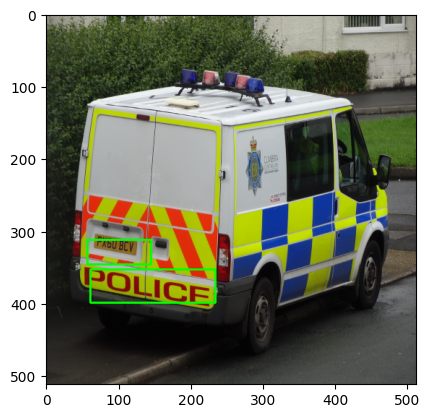

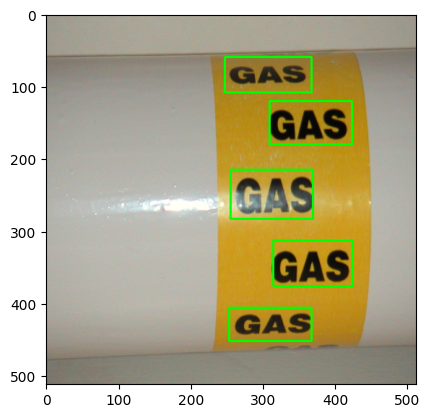

In [64]:
# Solely predict on entirely new, unseen data (from the Test directory)
for i in os.listdir('Test'):
    img = cv2.cvtColor(cv2.imread(os.path.join('Test', i)), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(512,512))
    img = (img - 127.5)/127.5
    predict_func(model, np.expand_dims(img, axis= 0), 0.5, f'sample - {i}')

## Pruning and Fine-Tuning

We apply pruning to the whole model and see its effects in the model summary.
We start with 30% sparsity (30% of the original weights 'switched off') and end with 60% sparsity.

There exists a [comprehensive guide](https://www.tensorflow.org/model_optimization/guide/pruning/comprehensive_guide.md) on how to prune a model for efficiency improvements.

In [38]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Perform pruning for 2 epochs on relatively small batches
batch_size = 32
epochs = 2

# 10% of the data set will be put aside for validation
validation_split = 0.1

num_images = X_train.shape[0]
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

In [39]:
# Define pruning parameters
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

In [40]:
pruned_model = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires this recompile
pruned_model.compile(loss=loss_func, optimizer=opt, metrics=['accuracy'])

pruned_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 prune_low_magnitude_Conv1 (Pru  (None, 256, 256, 32  1730       ['input_1[0][0]']                
 neLowMagnitude)                )                                                                 
                                                                                                  
 prune_low_magnitude_bn_Conv1 (  (None, 256, 256, 32  129        ['prune_low_magnitude_Conv1[0][0]
 PruneLowMagnitude)             )                                ']                           

### Training and model comparison

With pruning initialized, we now further fine-tune the adapted, new `pruned_model` for two epochs.

In [41]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

pruned_model.fit(X_train, Y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_split=validation_split,
                 callbacks=callbacks)

Epoch 1/2
10/10 [==============================] - 328s 28s/step - loss: 17.2739 - accuracy: 0.0499 - val_loss: 26.4805 - val_accuracy: 0.0515
Epoch 2/2
10/10 [==============================] - 285s 29s/step - loss: 17.4552 - accuracy: 0.0502 - val_loss: 26.4474 - val_accuracy: 0.0513


In [42]:
_, pruned_model_acc = pruned_model.evaluate(X_val, Y_val, verbose=0)
print('Pruned test accuracy:', pruned_model_acc)

Pruned test accuracy: 0.04707704856991768


The measure of accuracy was largely maintained (+/- 0.0007).
We now compress the pruned model (this becomes more effective as more weights are just $0$) and afterwards apply quantization to further reduce the model's footprint.

In [56]:
# strip_pruning() removes every pruning residue from training (variables that are not needed anymore)
pruned_keras_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

pruned_keras_model.save_weights(pruned_keras_file)
tf.keras.models.save_model(pruned_keras_model, pruned_keras_file, include_optimizer=False)
print('Pruned Keras model saved to:', pruned_keras_file)

Pruned Keras model saved to: model/detector_weights_keras_pruned.h5


We go a step further and turn this exportable Keras-based model `compressed_model` into a Tensorflow Light model file, which is mainly used for mobile deployment.

In [57]:
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_keras_model)
pruned_tflite_model = converter.convert()

pruned_keras_model.save_weights(pruned_tflight_file)

with open(pruned_tflight_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflight_file)

INFO:tensorflow:Assets written to: C:\Users\Marcus\AppData\Local\Temp\tmp5n5yhzix\assets


INFO:tensorflow:Assets written to: C:\Users\Marcus\AppData\Local\Temp\tmp5n5yhzix\assets


Saved pruned TFLite model to: model/detector_weights_tflight_pruned.tflite


In [60]:
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_keras_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_pruned_tflite_model = converter.convert()

_, quantized_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_pruned_tflite_file, 'wb') as f:
  f.write(quantized_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_pruned_tflite_file)

INFO:tensorflow:Assets written to: C:\Users\Marcus\AppData\Local\Temp\tmpfq8mzvre\assets


INFO:tensorflow:Assets written to: C:\Users\Marcus\AppData\Local\Temp\tmpfq8mzvre\assets


Saved quantized and pruned TFLite model to: C:\Users\Marcus\AppData\Local\Temp\tmpdql8jpn6.tflite


The resulting model `tmpdql8jpn6.tflite` is ~4 times smaller than the `detector_weights.h5`, while approximately sharing just the same accuracy as before.